# Learning `Deep Convolutional GAN`

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from dataset import ImageDataset

%matplotlib inline

In [2]:
data_dir = 'datasets/flowers'
save_file = 'datasets/saved/features{0}x{0}x{1}.pkl'

In [3]:
data = ImageDataset(data_dir=data_dir, size=25, flatten=True, grayscale=True)
# data.create()
# data.save(save_file.format(data.size, data.channel), force=True)
data = data.load(save_file.format(data.size, data.channel))

In [4]:
X_train, y_train, X_test, y_test = data.train_test_split(test_size=0.1)
print(data.features.shape, data.channel)

(3670, 625) 1


### Plot a random image

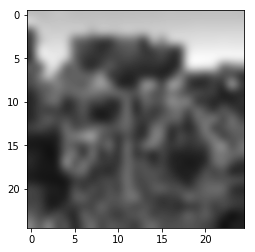

In [5]:
sample_image = X_test[3]
sample_image = sample_image.reshape([data.size, data.size])
plt.imshow(sample_image, cmap='gray')
plt.show()

## Hyperparams

In [6]:
# Inputs
img_size = data.size
img_channel = data.channel
img_size_flat = img_size * img_size * img_channel

# Network
conv_filter = 5
deconv_filter = 3
strides = [1, 2, 2, 1]
conv_1 = 16
conv_2 = 32
fc_1_size = 1024
fc_2_size = 1

# Training
learning_rate = 1e-3
batch_size = 24

## Building the Network

### Helper functions

In [7]:
# Weight initializer
def weight(shape, layer_name):
    return tf.get_variable(layer_name, shape, initializer=tf.truncated_normal_initializer(stddev=0.2))

# Bias initializer
def bias(shape, layer_name):
    return tf.get_variable(layer_name, [shape], initializer=tf.constant_initializer(0))

# Convolutional block
def conv_block(layer, W, b):
    layer = tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return layer

# Deconvolutional block
def deconv_block(layer, W, b, activation_fn=tf.nn.relu, batch_norm=None):
    layer = tf.nn.conv2d(layer, W, strides=[1, 2, 2, 1], padding='SAME')
    layer = layer + b
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, epsilon=1e-5, scope=batch_norm)
    layer = activation_fn(layer)
    return layer

# Fully connected layer
def fully_connected(layer, W, b, use_relu=True):
    layer = tf.matmul(layer, W) + b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

# Flatten layer
def flatten(layer):
    shape = layer.get_shape()
    features = np.array(shape[1:4], dtype=np.int32).prod()
    flattened = tf.reshape(layer, [-1, features])
    return flattened, features

### Discriminator `(Deep Convolutional neural net)`

In [8]:
def discriminator(image, reuse=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:
        # 1st convolutional block
        d_conv_W1 = weight(shape=[conv_filter, conv_filter, img_channel, conv_1], layer_name='d_conv_W1')
        d_conv_b1 = bias(shape=conv_1, layer_name='d_conv_b1')
        d_conv_1 = conv_block(image, d_conv_W1, d_conv_b1)
        # 2nd convolutional block
        d_conv_W2 = weight(shape=[conv_filter, conv_filter, conv_1, conv_2], layer_name='d_conv_W2')
        d_conv_b2 = bias(shape=conv_2, layer_name='d_conv_b2')
        d_conv_2 = conv_block(d_conv_1, d_conv_W2, d_conv_b2)
        # Flatten layer
        flattened, features = flatten(d_conv_2)
        # 1st Fully connected layer
        d_fc_W1 = weight(shape=[features, fc_1_size], layer_name='d_fc_W1')
        d_fc_b1 = bias(shape=fc_1_size, layer_name='d_fc_b1')
        fc_1 = fully_connected(flattened, d_fc_W1, d_fc_b1, use_relu=True)
        # 2nd Fully connected layer
        d_fc_W2 = weight(shape=[fc_1_size, fc_2_size], layer_name='d_fc_W2')
        d_fc_b2 = bias(shape=fc_2_size, layer_name='d_fc_b2')
        fc_2 = fully_connected(fc_1, d_fc_W2, d_fc_b2, use_relu=False)
        return fc_2

### Generator `(Deep Deconvolutional neural net)`

In [9]:
def generator(z, batch_size, z_dim):
    scale = img_size * 2
    up_scale = scale * scale
    # 1st Deconvolutional block
    g_deconv_W1 = weight(shape=[z_dim, up_scale], layer_name='g_deconv_W1')
    g_deconv_b1 = bias(shape=up_scale, layer_name='g_deconv_b1')
    g_deconv_1 = tf.matmul(z, g_deconv_W1) + g_deconv_b1
    g_deconv_1 = tf.reshape(g_deconv_1, [-1, scale, scale, img_channel])
    g_deconv_1 = tf.contrib.layers.batch_norm(g_deconv_1, epsilon=1e-5, scope='bn_G1')
    g_deconv_1 = tf.nn.relu(g_deconv_1)
    # 2nd Deconvolutional block
    g_deconv_W2 = weight(shape=[deconv_filter, deconv_filter, img_channel, z_dim//2], layer_name='g_deconv_W2')
    g_deconv_b2 = bias(shape=z_dim//2, layer_name='g_deconv_b2')
    g_deconv_2 = deconv_block(g_deconv_1, g_deconv_W2, g_deconv_b2, batch_norm='bn_G2')
    g_deconv_2 = tf.image.resize_images(g_deconv_2, [scale, scale])
    # 3rd Deconvolutional block
    g_deconv_W3 = weight(shape=[deconv_filter, deconv_filter, z_dim//2, z_dim//4], layer_name='g_deconv_W3')
    g_deconv_b3 = bias(shape=z_dim//4, layer_name='g_deconv_b3')
    g_deconv_3 = deconv_block(g_deconv_2, g_deconv_W3, g_deconv_b3, batch_norm='bn_G3')
    g_deconv_3 = tf.image.resize_images(g_deconv_3, [scale, scale])
    # Final Deconvolutional block
    g_deconv_W4 = weight(shape=[1, 1, z_dim//4, 1], layer_name='g_deconv_W4')
    g_deconv_b4 = bias(shape=1, layer_name='g_deconv_b4')
    g_deconv_4 = deconv_block(g_deconv_3, g_deconv_W4, g_deconv_b4, activation_fn=tf.nn.sigmoid)
    return g_deconv_4

In [10]:
tf.reset_default_graph()
z_dim = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dim])

In [11]:
gen_img = generator(z_placeholder, 1, z_dim)
z_batch = np.random.normal(0, 1, [1, z_dim])

(1, 25, 25, 1)


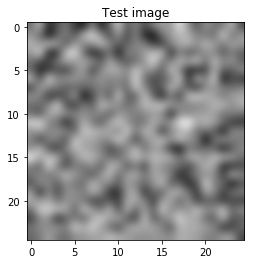

In [12]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_img = sess.run(gen_img, feed_dict={z_placeholder: z_batch})
    print(test_img.shape)
    plt.title('Test image')
    plt.imshow(test_img.reshape([img_size, img_size]), cmap='gray')

In [13]:
tf.reset_default_graph()

# Placeholder
z_placeholder = tf.placeholder(tf.float32, [None, z_dim], name='z_placeholder')
X_placeholder = tf.placeholder(tf.float32, [None, img_size_flat], name='X_placeholder')
X_image = tf.reshape(X_placeholder, [-1, img_size, img_size, img_channel])

# Genenrated img
Gz = generator(z_placeholder, batch_size, z_dim)
# Discriminator
# Prob. for real img
Dx = discriminator(X_image)
# Prob. for generated img
Dg = discriminator(Gz, reuse=True)

### Loss functions

In [14]:
# Discriminator loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
# Generator loss
g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

### Retrieve Trainable Vars

In [15]:
t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

print([var.name for var in d_vars])
print([var.name for var in g_vars])

['d_conv_W1:0', 'd_conv_b1:0', 'd_conv_W2:0', 'd_conv_b2:0', 'd_fc_W1:0', 'd_fc_b1:0', 'd_fc_W2:0', 'd_fc_b2:0']
['g_deconv_W1:0', 'g_deconv_b1:0', 'g_deconv_W2:0', 'g_deconv_b2:0', 'g_deconv_W3:0', 'g_deconv_b3:0', 'g_deconv_W4:0', 'g_deconv_b4:0']


### Optimization

In [16]:
# Discriminator optimization
d_opt_real = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_real, var_list=d_vars)
d_opt_fake = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_fake, var_list=d_vars)
# Generator optimization
g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

## Tensorboard stuff

In [17]:
saver = tf.train.Saver()

# Henceforth, reuse variables
tf.get_variable_scope().reuse_variables()

# Summaries
tf.summary.scalar('Generator_Loss', g_loss)
tf.summary.scalar('Discriminator_Loss_Real', d_loss_real)
tf.summary.scalar('Discriminator_Loss_Fake', d_loss_fake)
img_4_tensorboard = generator(z_placeholder, batch_size, z_dim)
tf.summary.image('Generated_Images', img_4_tensorboard, max_outputs=5)
# merge all summaries
merged = tf.summary.merge_all()

# Directories
tensorboard_dir = 'tensorboard/'
log_dir = os.path.join(tensorboard_dir, '{:%d-%b-%Y  %H-%M-%S-%p}'.format(dt.datetime.now()))
save_path = 'models/'

writer = tf.summary.FileWriter(log_dir, sess.graph)

# Create checkpoint dir
if not tf.gfile.Exists(save_path):
    # tf.gfile.DeleteRecursively(save_path)
    tf.gfile.MakeDirs(save_path)

Iterations: 99	d_loss_real: 680.8481	d_loss_fake: 2.9335	Training: 0:00:17.451295 agooo	Iterations: 0 at Mon Nov 06, 2017 at 22:34:54 PM


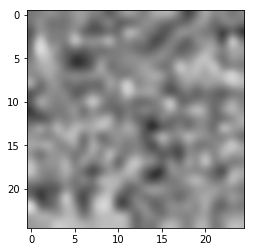

Estimate: [[-38.06853867]]

Iterations: 199	Training time: 0:01:33.304328	d_loss_fake: 1.1630	d_loss_real: 0.0000	g_loss: 0.000000	Iterations: 200 at Mon Nov 06, 2017 at 22:36:27 PM


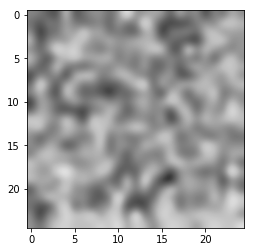

Estimate: [[-28.05067062]]

Iterations: 399	Training time: 0:03:01.426304	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.00000000	Iterations: 400 at Mon Nov 06, 2017 at 22:37:55 PM


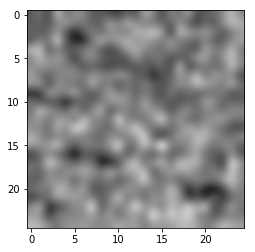

Estimate: [[-29.32688522]]

Iterations: 599	Training time: 0:04:32.001734	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.0000	Iterations: 600 at Mon Nov 06, 2017 at 22:39:26 PM


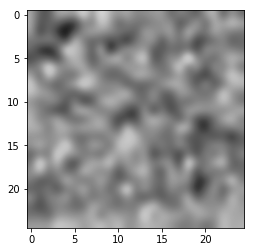

Estimate: [[-29.99246788]]

Iterations: 799	Training time: 0:06:04.565055	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.0000	Iterations: 800 at Mon Nov 06, 2017 at 22:40:58 PM


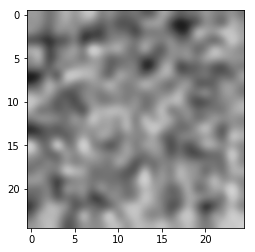

Estimate: [[-29.09312248]]

Iterations: 999	Training time: 0:07:34.733123	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.0000	Iterations: 1,000 at Mon Nov 06, 2017 at 22:42:28 PM


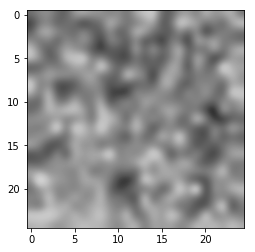

Estimate: [[-31.41239548]]

Iterations: 1,108	Training time: 0:08:22.057748	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.0000

KeyboardInterrupt: 

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# restore any checkpoints if it exists
if len(os.listdir(save_path)) > 1:
    saver.restore(sess=sess, save_path=save_path)

train_start = dt.datetime.now()
# Pre-train discriminator
for i in range(100):
    fake_img_batch = np.random.normal(0, 1, [batch_size, z_dim])
    real_img_batch = data.next_batch(batch_size)[0]
    _, _, d_real, d_fake = sess.run([d_opt_fake, d_opt_real, 
                                     d_loss_real, d_loss_fake],
                                    feed_dict={X_placeholder: real_img_batch, 
                                               z_placeholder: fake_img_batch})

    sys.stdout.write('\rIterations: {:,}\td_loss_real: {:.4f}\td_loss_fake: {:.4f}\tTraining: {:} ago'.format(i, d_real, d_fake, dt.datetime.now() - train_start))

# Train generator & discriminator together (dual each other)
train_start = dt.datetime.now()
for i in range(10000):
    real_img_batch = data.next_batch(batch_size)[0]
    fake_img_batch = np.random.normal(0, 1, [batch_size, z_dim])
    # Train discriminator
    _, _, d_real, d_fake = sess.run([d_opt_fake, d_opt_real,
                                     d_loss_real, d_loss_fake],
                                    feed_dict={X_placeholder: real_img_batch,
                                               z_placeholder: fake_img_batch})
    # Train generator
    gen_img = np.random.normal(0, 1, size=[batch_size, z_dim])
    _, gen_loss = sess.run([g_opt, g_loss], feed_dict={z_placeholder: gen_img})
    
    # Updating tensorboard
    if i % 50 == 0:
        # save model chkpt
        saver.save(sess=sess, save_path=save_path)
        # update tensorboard
        gen_img = np.random.normal(0, 1, size=[batch_size, z_dim])
        summary = sess.run(merged, feed_dict={X_placeholder: real_img_batch,
                                              z_placeholder: gen_img})
        writer.add_summary(summary=summary, global_step=i)
        
    # Logging
    if i % 200 == 0:
        # Every 1000 iterations, show a generated image
        print("\tIterations: {:,} at {:%a %h %d, %Y at %H:%M:%S %p}".format(i, dt.datetime.now()))
        gen_img = np.random.normal(0, 1, size=[1, z_dim])
        generated_images = generator(z_placeholder, 1, z_dim)
        images = sess.run(generated_images, {z_placeholder: gen_img})
        plt.imshow(images[0].reshape([img_size, img_size]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0]
        result = discriminator(tf.reshape(X_placeholder, [-1, img_size, img_size, img_channel]))
        estimate = sess.run(result, {X_placeholder: np.reshape(im, [-1, img_size_flat])})
        print("Estimate: {}\n".format(estimate))
    sys.stdout.write('\rIterations: {:,}\tTraining time: {:}\td_loss_fake: {:.4f}\td_loss_real: {:.4f}\tg_loss: {:.4f}'.format(i, dt.datetime.now() - train_start, d_fake, d_real, gen_loss))
